In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import missingno as msno

In [21]:
train = pd.read_csv('./data/train.csv')

In [22]:
# missing values
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [ ]:
# percentage of missing values
train.isnull().sum()/len(train)*100

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

In [6]:
# Missingno in Age can be filled with median age of VIP and non-VIP

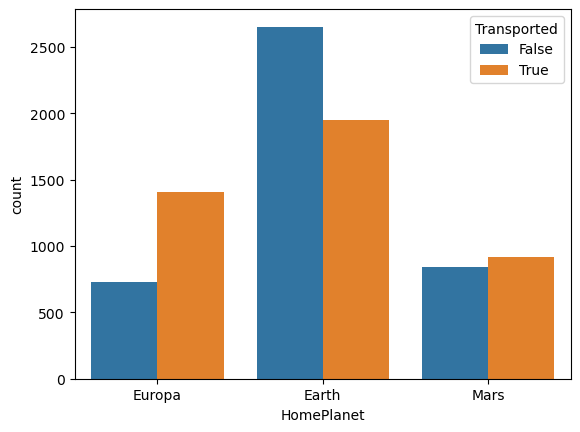

In [7]:
# HomePlanet
sns.countplot(x='HomePlanet', hue='Transported', data=train)
plt.show()

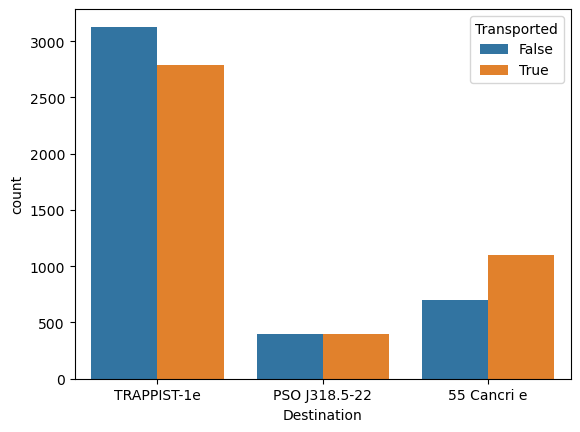

In [8]:
# Destination
sns.countplot(x='Destination', hue='Transported', data=train)
plt.show()

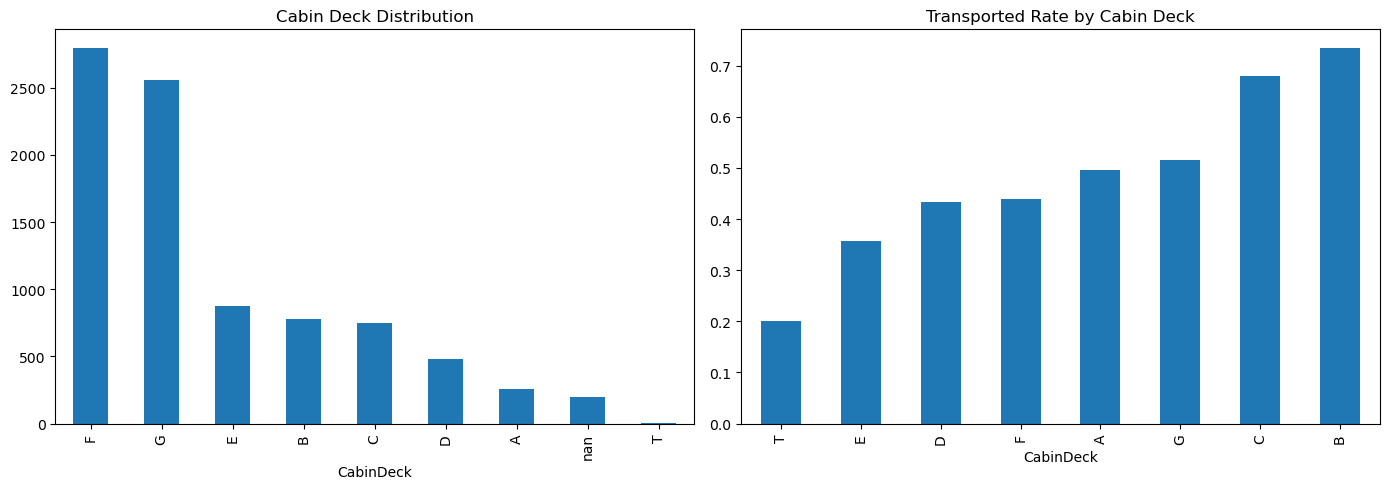

In [35]:
# Cabin
train[['CabinDeck','CabinNum','CabinSide']] = train['Cabin'].str.split('/', expand=True)

# Deck
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train['CabinDeck'].value_counts(dropna=False).plot(
    kind='bar',
    ax=axes[0],                     
    title='Cabin Deck Distribution'
)

deck_rate = (
    train
    .groupby('CabinDeck')['Transported']
    .mean()
    .sort_values()
)
deck_rate.plot(
    kind='bar',
    ax=axes[1],      
    title='Transported Rate by Cabin Deck'
)

plt.tight_layout()
plt.show()

/var/folders/m_/gq3fgb6x2rs_xpbs_2llxbvc0000gn/T/ipykernel_1989/2640810957.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('CabinNum_bin')['Transported']


<Axes: title={'center': 'Transported Rate by CabinNum Bin'}, xlabel='CabinNum_bin'>

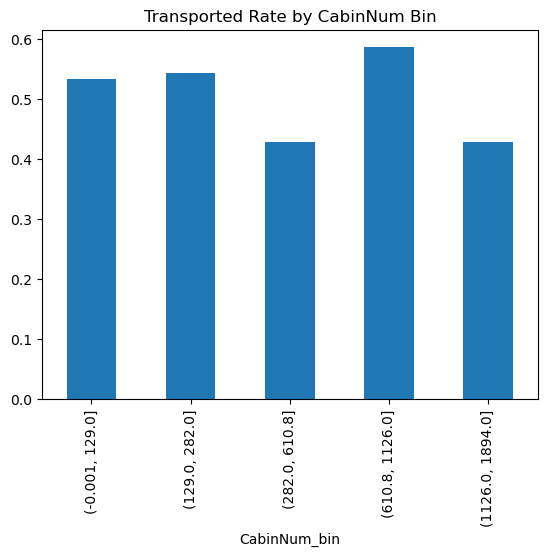

In [31]:
# Num
train['CabinNum'] = pd.to_numeric(train['CabinNum'], errors='coerce')

# divide range into 5 bins
train['CabinNum_bin'] = pd.qcut(
    train['CabinNum'], q=5, duplicates='drop'
)
(
    train
    .groupby('CabinNum_bin')['Transported']
    .mean()
    .plot(kind='bar', title='Transported Rate by CabinNum Bin')
)


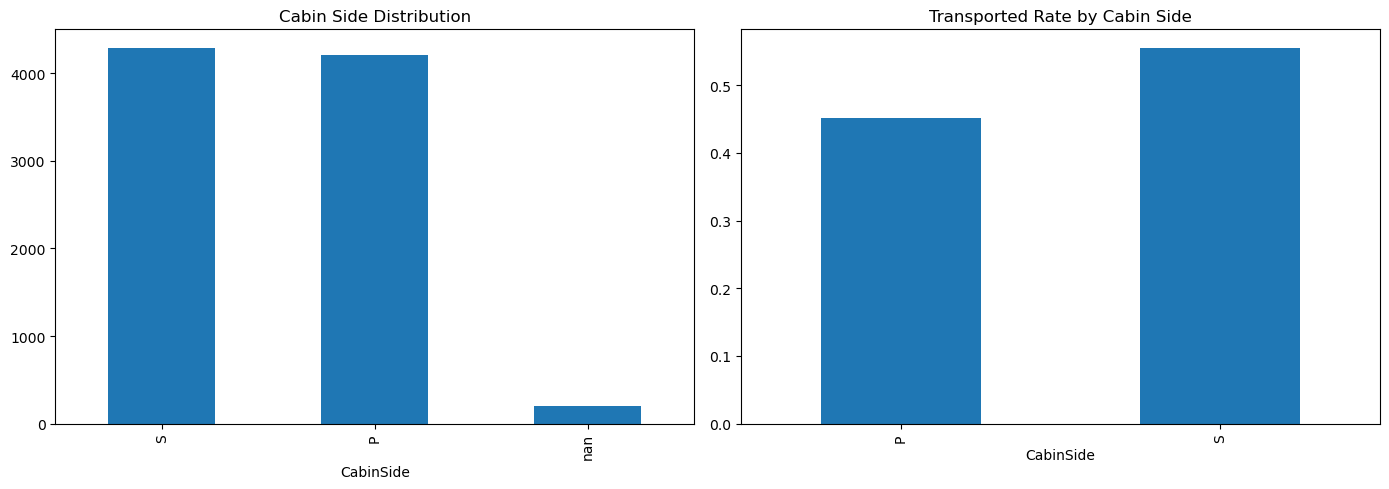

In [36]:
# Cabin
train[['CabinDeck','CabinNum','CabinSide']] = train['Cabin'].str.split('/', expand=True)

# Deck
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train['CabinSide'].value_counts(dropna=False).plot(
    kind='bar',
    ax=axes[0],                     
    title='Cabin Side Distribution'
)

side_rate = (
    train
    .groupby('CabinSide')['Transported']
    .mean()
)

side_rate.plot(
    kind='bar',
    ax=axes[1],      
    title='Transported Rate by Cabin Side'
)

plt.tight_layout()
plt.show()


In [ ]:
# 특정 Deck에 Side가 한쪽만 몰려 있을 수도 있음
# Side 효과처럼 보이던 게 Deck 효과의 부산물일 수 있음
pd.crosstab(
    train['CabinDeck'],
    train['CabinSide'],
    normalize='index'
)

CabinSide,P,S
CabinDeck,,
A,0.457031,0.542969
B,0.453145,0.546855
C,0.456493,0.543507
D,0.518828,0.481172
E,0.489726,0.510274
F,0.514674,0.485326
G,0.498632,0.501368
T,0.800000,0.200000


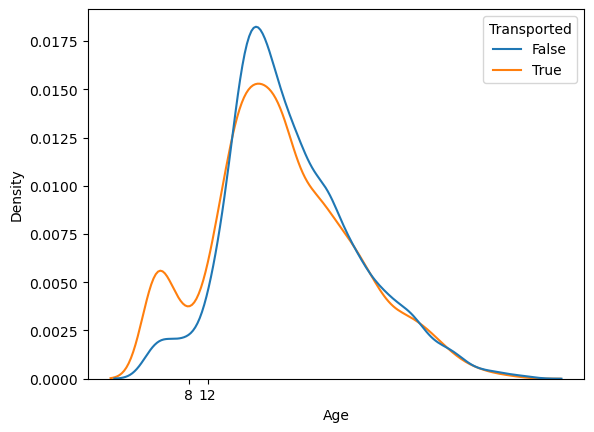

In [18]:
# Age
sns.kdeplot(data=train, x='Age', hue='Transported')
plt.xticks(np.arange(8, 14, 4)) 
plt.show()

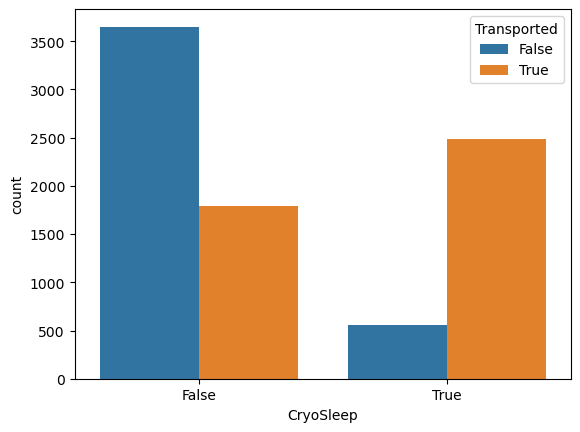

In [10]:
# CryoSleep
sns.countplot(x='CryoSleep', hue='Transported', data=train)
plt.show()


In [ ]:
# VIP
train['VIP'].value_counts()

VIP
False    8291
True      199
Name: count, dtype: int64

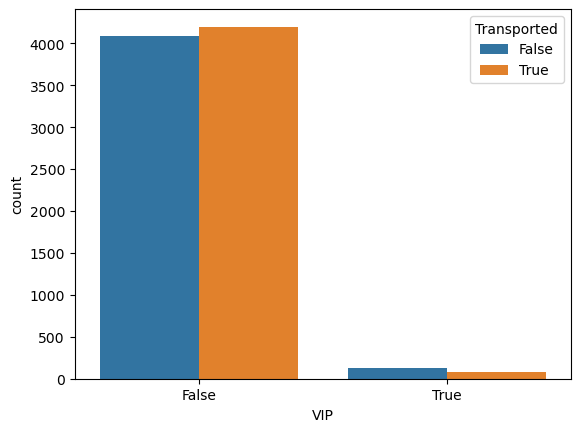

In [ ]:
sns.countplot(x='VIP', hue='Transported', data=train)
plt.show()

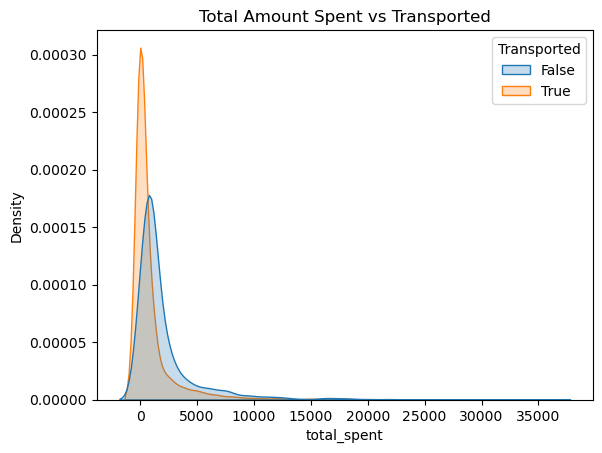

In [15]:
# Total amount spent
train['total_spent'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck']
sns.kdeplot(data=train, x='total_spent', hue='Transported', fill=True)
plt.title('Total Amount Spent vs Transported')
plt.show()

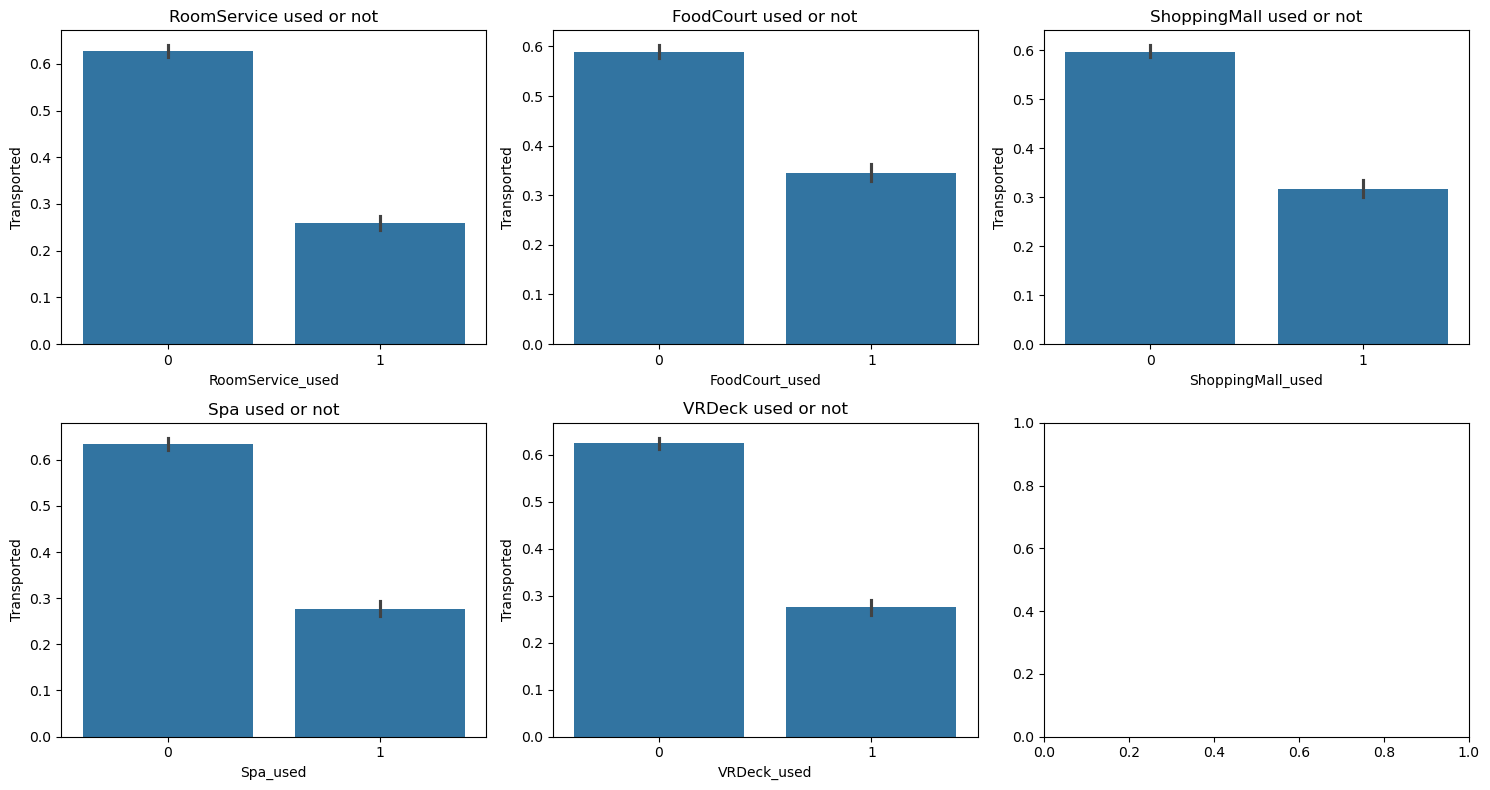

In [17]:
# Analyzing individual spending categories
cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  
axes = axes.flatten()                    

for i, c in enumerate(cols):             
    train[c + '_used'] = (train[c] > 0).astype(int)
    sns.barplot(
        data=train,
        x=c + '_used',
        y='Transported',
        ax=axes[i]                       
    )
    axes[i].set_title(c + ' used or not')

plt.tight_layout()                       
plt.show()                               


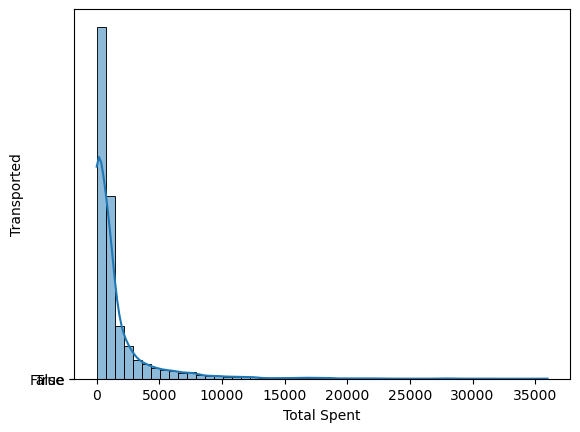

In [24]:
sns.histplot(train['total_spent'], bins=50, kde=True)
plt.yticks([0, 1], ['False', 'True'])
plt.xlabel('Total Spent')
plt.ylabel('Transported')
plt.show()

In [26]:
# Mutual Information
from sklearn.feature_selection import mutual_info_classif

In [ ]:
y = train['Transported'].astype(int)
X = train.drop(columns=['Transported'])

spend_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
X[spend_cols] = X[spend_cols].fillna(0)


for col in X.select_dtypes(include="object"):
    X[col], _ = X[col].factorize()

discrete_features = X.dtypes == "int64"


In [35]:
mi = mutual_info_classif(
    X,
    y,
    discrete_features=discrete_features,
    random_state=42
)
mi_scores = (
    pd.Series(mi, index=X.columns, name="MI")
      .sort_values(ascending=False)
)

ValueError: Input X contains NaN.